In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Contents

* [Executive Summary](#Executive-Summary)
* [Base Model](#Base-Model)
* [PCA Based Model](#PCA-Based-Model)
* [Anayze Learning Curve](#Analyze-Learning-Curve)

# Executive Summary

| Model | Score |
|------|------|------|
|   Base Model  | 82.91% | 
|   PCA Based Model  | 82.88% |

The best results were achieved by NOT using PCA and using the following parameters:
* {'loss': 'hinge', 'n_iter': 7, 'penalty': 'none'}

# fc1000 Feature Engineering

#### Importing Libraries

In [68]:
# from skicaffe import SkiCaffe
import sys, os, random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import normalize
%matplotlib inline

In [3]:
import sklearn
sklearn.__version__

'0.18.1'

#### Set Caffe root

The Caffe binary paths are based on the binaries provided by John. The pre-trained ResNet-50 can be found here:
https://github.com/KaimingHe/deep-residual-networks

In [4]:
# caffe_root = '/usr/local/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
# sys.path.insert(0, caffe_root + 'python')
# model_prototxt = '/home/ssnazrul/WIFIRE/ResNet50_Analysis/models/ResNet-50-deploy.prototxt'
# model_trained = '/home/ssnazrul/WIFIRE/ResNet50_Analysis/models/ResNet-50-model.caffemodel'

#### Inception Model

Setting up a Deep Learning model based on ResNet-50 that has been pre-trained on ImageNet data for our Inception Model. Check appropriate layer name here:
http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006

In [5]:
# DLmodel = SkiCaffe(caffe_root=caffe_root, 
#                    model_prototxt_path=model_prototxt, 
#                    model_trained_path=model_trained, 
#                    layer_name='fc1000')

#### Feature Engineering

Passing WIFIRE data through the Inception Model for Feature Engineering.

In [6]:
# #Source Path
# src_path = '/home/ssnazrul/WIFIRE/Processed_Data/LabelledTiles_Fuel_EqualArea/JPG_Files'

# #Paths
# image_types = ('.jpg')
# image_paths = []
# for root, dirs, files in os.walk(src_path):
#     image_paths.extend([os.path.join(root,f) for f in files if f.endswith(image_types)])
    
# #Labels    
# labels = [os.path.basename(f).split('_')[-1][:-4] for f in image_paths]

# #DataFrame
# df = pd.DataFrame({'Path':image_paths, 'Labels':labels})

In [7]:
df = pd.read_csv('~/WIFIRE/Processed_Data/LabelledTiles_Fuel_EqualArea/Reference_Fuel_EqualArea_18May2017_LabelsFromClustering.csv')
df.head()

,Image,FuelFileIndex,NewLabel
0,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,90,B
1,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,104,B
2,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,202,B
3,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,378,B
4,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,409,B


In [8]:
idx = df.FuelFileIndex
labels = df.NewLabel

#### Classification

The engineered features are classified using a linear classifier. Based on available memory, the Logistic Classifier calculates the weights either by matrix manipulation or Stochastic Gradient Descent.

In [9]:
root = "/home/ssnazrul/WIFIRE/ResNet50_Analysis/WIFIRE_Engineered/"

image_features_df = pd.read_csv(root+"WIFIRE_engineered_features_new.csv",  delimiter=',', header=None)

In [10]:
image_features = image_features_df.ix[idx,:].values #convert df to np array

# Base Model

The base model uses SGD's default parameters at 5 fold cross validation.

In [11]:
X = normalize(image_features)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge','log'),
              'penalty':('l1','l2','none'),
              'n_iter':range(1,10)}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2', 'none'), 'loss': ('hinge', 'log'), 'n_iter': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [13]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

In [14]:
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

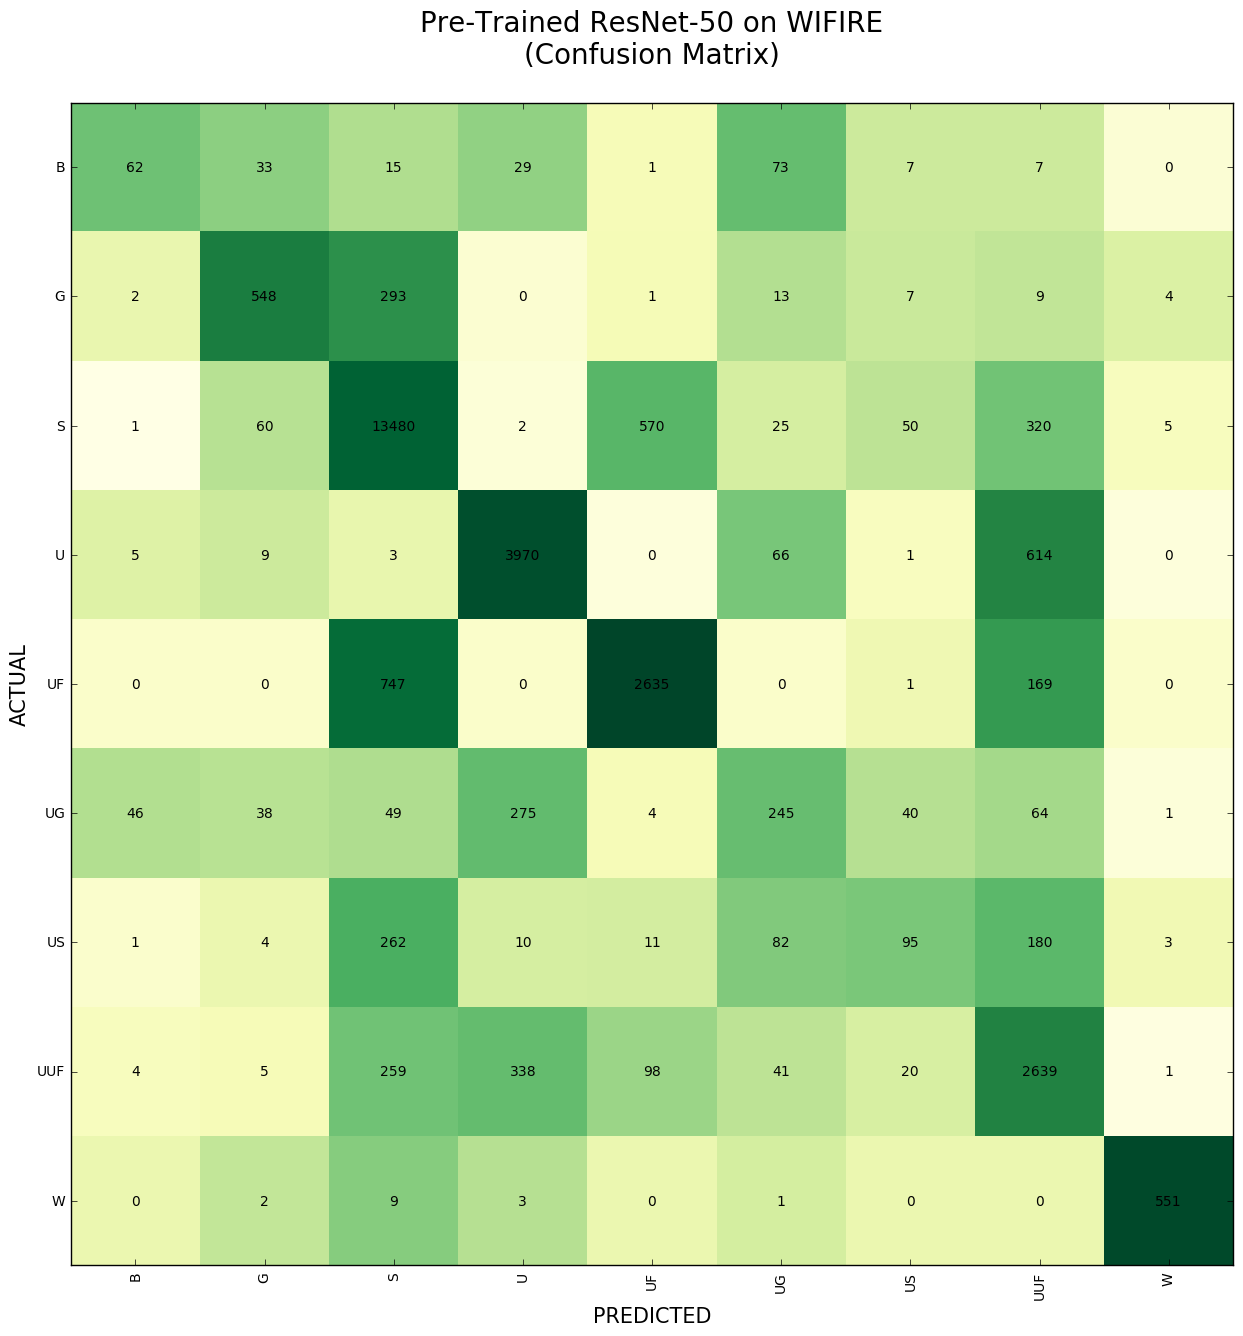

In [15]:
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(y_test)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on WIFIRE\n(Confusion Matrix)\n', fontsize=20);

#### Optimum Parameters

In [20]:
classifier.best_params_

{'loss': 'hinge', 'n_iter': 7, 'penalty': 'none'}

#### Additional Report

In [28]:
print('Classification Report')
print(classification_report(y_test, predict_target))
print('\nROC AUC')
for f in np.unique(y_test):
    y_true = np.array(y_test == f, dtype=int)
    y_pred = np.array(predict_target == f, dtype=int)
    try:
        score = str(roc_auc_score(y_true, y_pred))
    except:
        score = 'FAILED!' 
    if f == 'Argriculture':
        print(f+':\t'+score)
    else:
        print(f+':\t\t'+score)
print('\nClassification Score for Validation Set')
print(((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100)

Classification Report
             precision    recall  f1-score   support

          B       0.51      0.27      0.36       227
          G       0.78      0.62      0.70       877
          S       0.89      0.93      0.91     14513
          U       0.86      0.85      0.85      4668
         UF       0.79      0.74      0.77      3552
         UG       0.45      0.32      0.37       762
         US       0.43      0.15      0.22       648
        UUF       0.66      0.78      0.71      3405
          W       0.98      0.97      0.97       566

avg / total       0.82      0.83      0.82     29218


ROC AUC
B:		0.635546319479
G:		0.809764749282
S:		0.908749877849
U:		0.911854791561
UF:		0.857573290338
UG:		0.655472287833
US:		0.57109735888
UUF:		0.861116929722
W:		0.986504805565

Classification Score for Validation Set
82.9112191115


# PCA Based Model

#### Original Dimensions

In [44]:
from sklearn.decomposition import PCA

M = normalize(image_features)

pca = PCA(n_components=np.shape(M)[1]) 
T = pca.fit_transform(M) 
T.shape

(146087, 1000)

#### Variance Captured by PCA

In [ ]:
cumulative_explained = np.cumsum(pca.explained_variance_ratio_) 

[ 0.3175009   0.13916154  0.05197496  0.03978621  0.02752406  0.02518572
  0.02162185  0.02071454  0.01803549  0.01522132]


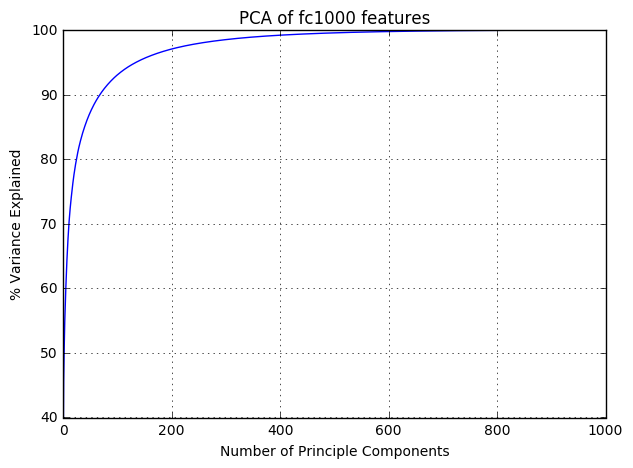

In [59]:
plt.figure(figsize=(7,5))
plt.plot(cumulative_explained*100);
plt.ylim([40,100])
plt.grid()
plt.title('PCA of fc1000 features', fontsize=12)
plt.ylabel('% Variance Explained')
plt.xlabel('Number of Principle Components')

print(pca.explained_variance_ratio_[:10])

In [46]:
pca = PCA(n_components=400) 
T = pca.fit_transform(M) 

In [47]:
n_samples = len(df)
X = normalize(T)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [48]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge','log'),
              'penalty':('l1','l2','none'),
              'n_iter':range(1,10)}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2', 'none'), 'loss': ('hinge', 'log'), 'n_iter': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [49]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

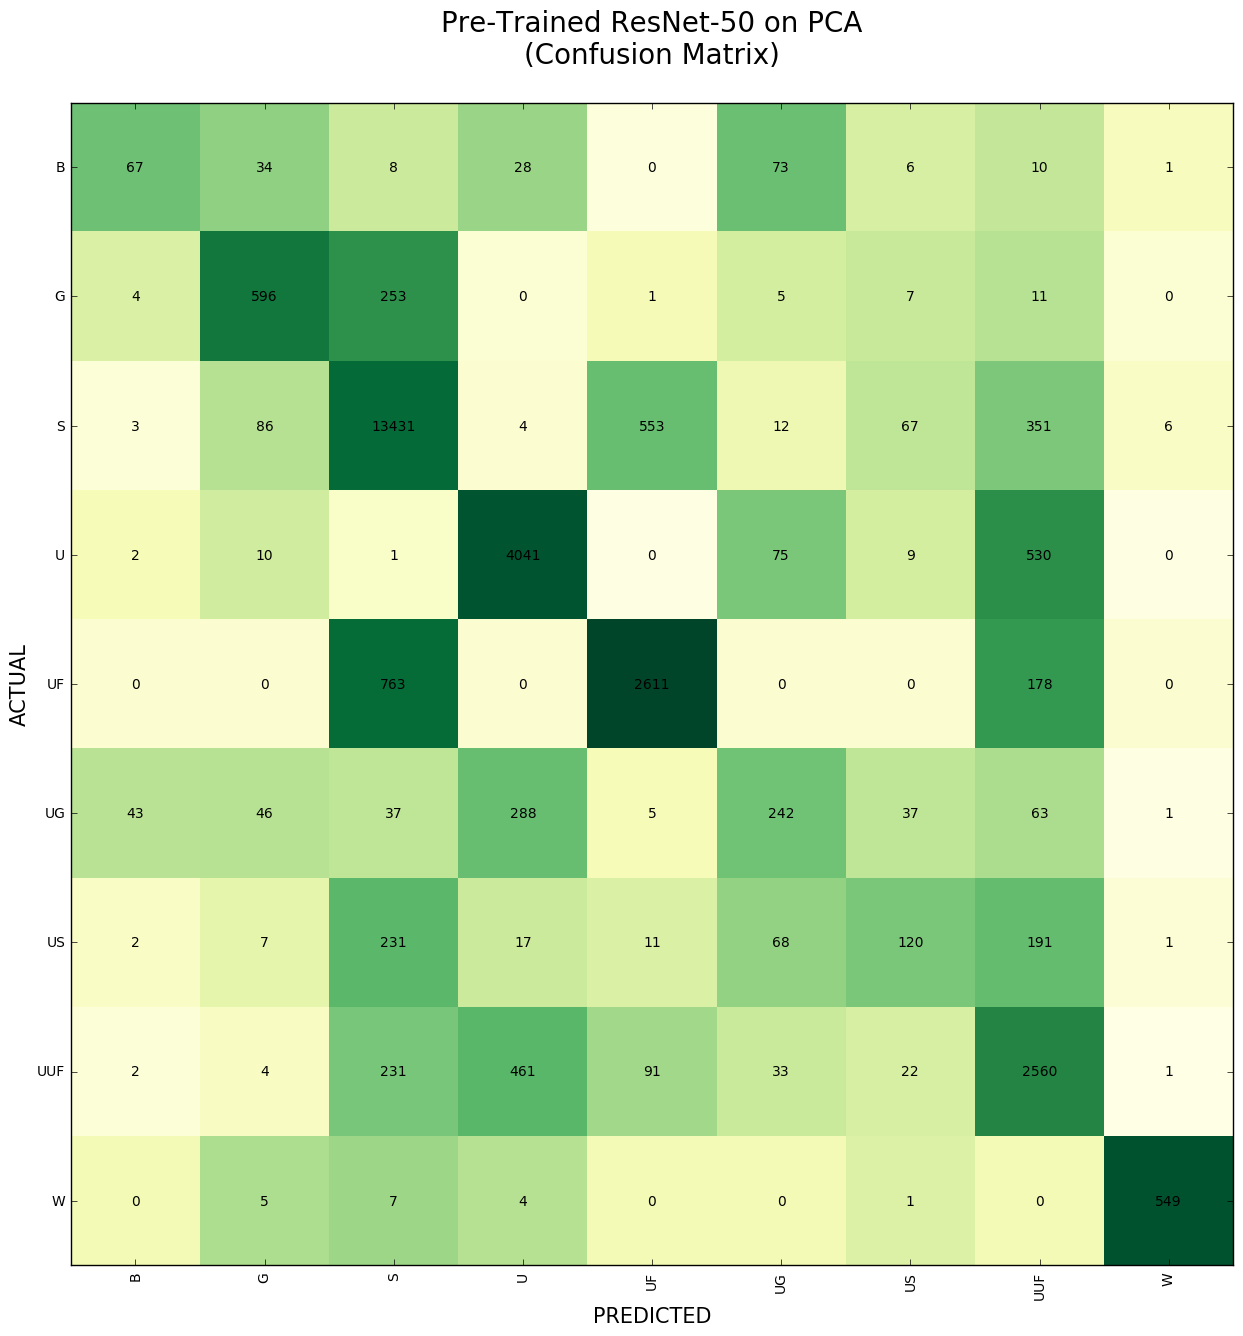

In [50]:
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
    
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(y_test)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on PCA\n(Confusion Matrix)\n', fontsize=20);

#### Optimal Parameters

In [51]:
classifier.best_params_

{'loss': 'log', 'n_iter': 9, 'penalty': 'none'}

#### Additional Report

In [52]:
print('Classification Report')
print(classification_report(y_test, predict_target))
print('\nROC AUC')
for f in np.unique(y_test):
    y_true = np.array(y_test == f, dtype=int)
    y_pred = np.array(predict_target == f, dtype=int)
    try:
        score = str(roc_auc_score(y_true, y_pred))
    except:
        score = 'FAILED!' 
    if f == 'Argriculture':
        print(f+':\t'+score)
    else:
        print(f+':\t\t'+score)
print('\nClassification Score for Validation Set')
print(((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100)

Classification Report
             precision    recall  f1-score   support

          B       0.54      0.30      0.38       227
          G       0.76      0.68      0.72       877
          S       0.90      0.93      0.91     14513
          U       0.83      0.87      0.85      4668
         UF       0.80      0.74      0.77      3552
         UG       0.48      0.32      0.38       762
         US       0.45      0.19      0.26       648
        UUF       0.66      0.75      0.70      3405
          W       0.98      0.97      0.98       566

avg / total       0.82      0.83      0.82     29218


ROC AUC
B:		0.646611275533
G:		0.836407436121
S:		0.910665952436
U:		0.916506604747
UF:		0.854662456571
UG:		0.654118768433
US:		0.589984962211
UUF:		0.85007807481
W:		0.984807824268

Classification Score for Validation Set
82.8838387296


# Analyze Learning Curve

In [74]:
from sklearn.model_selection import learning_curve

X = normalize(image_features)
y = np.array(labels)

clf = SGDClassifier(n_jobs=-1, loss='hinge', n_iter=7, 
                    penalty='none', random_state=0)

train_percent = np.array([0.60,0.70,0.80,0.90,1.])
                         
train_sizes, train_scores, valid_scores = learning_curve(clf, X, y, cv=5, train_sizes=train_percent)    

('Optimal Score:\t', 0.77928244955415771)


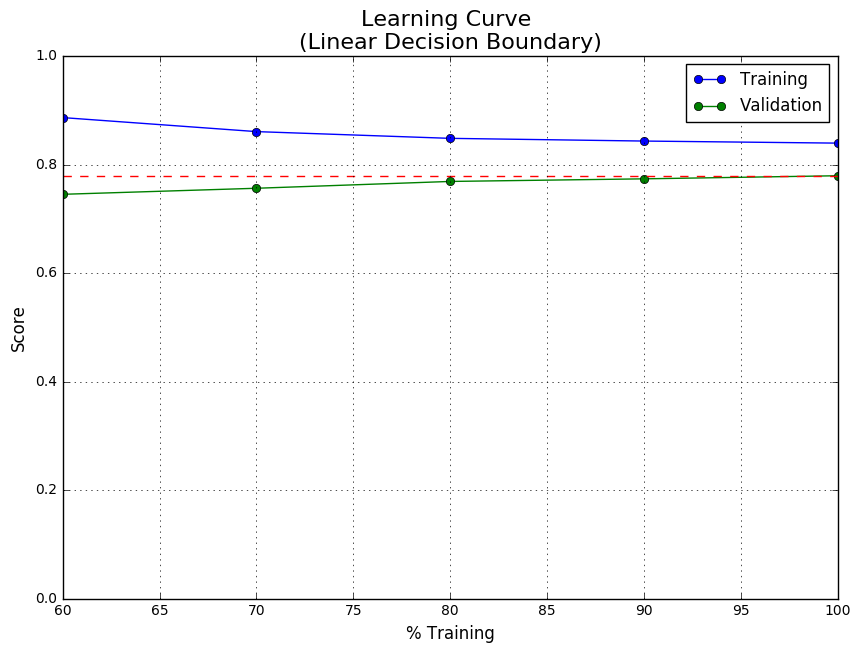

In [75]:
train_av = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

valid_av = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10,7))
plt.plot(train_percent*100, train_av, 'bo-', label="Training")
plt.plot(train_percent*100, valid_av, 'go-', label="Validation")
plt.xlabel('% Training',fontsize=12)
plt.ylabel('Score',fontsize=12)
plt.ylim(0,1)
plt.axhline(y=valid_av[-1], color = 'r', linestyle ='--')
plt.title('Learning Curve \n(Linear Decision Boundary)',fontsize=16)
plt.legend(fontsize=12)
plt.grid()
print('Optimal Score:\t',valid_av[-1])

In [69]:
from sklearn.model_selection import learning_curve

X = normalize(image_features)
y = np.array(labels)

clf = RandomForestClassifier(n_jobs=-1, max_depth=15, bootstrap=False, 
                    max_features=10, criterion='entropy',random_state=0)

train_percent = np.array([0.60,0.70,0.80,0.90,1.])
                         
train_sizes, train_scores, valid_scores = learning_curve(clf, X, y, cv=5, train_sizes=train_percent)    

('Optimal Score:\t', 0.78191172764301242)


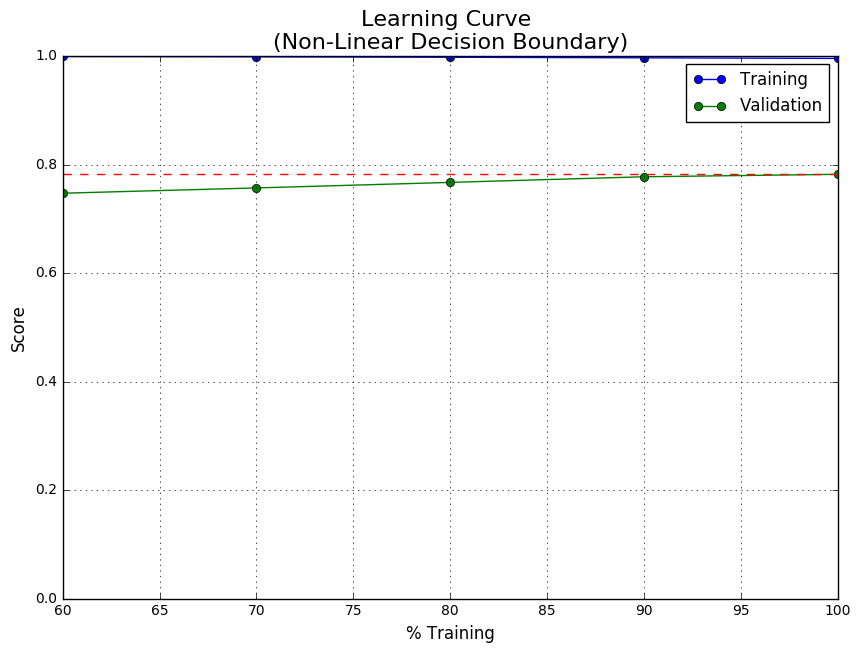

In [73]:
train_av = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

valid_av = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10,7))
plt.plot(train_percent*100, train_av, 'bo-', label="Training")
plt.plot(train_percent*100, valid_av, 'go-', label="Validation")
plt.xlabel('% Training',fontsize=12)
plt.ylabel('Score',fontsize=12)
plt.ylim(0,1)
plt.axhline(y=valid_av[-1], color = 'r', linestyle ='--')
plt.title('Learning Curve \n(Non-Linear Decision Boundary)',fontsize=16)
plt.legend(fontsize=12)
plt.grid()
print('Optimal Score:\t',valid_av[-1])